# Mount the google drive

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the necessary Libraries

---



In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import pandas
import random
import skimage
import warnings
import csv
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import threshold_otsu
from skimage.filters import threshold_otsu
from prettytable import PrettyTable
from sklearn.cluster import KMeans
from skimage.measure import shannon_entropy
from skimage import io, filters, feature
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Gray Scale Conversion of all classes

---



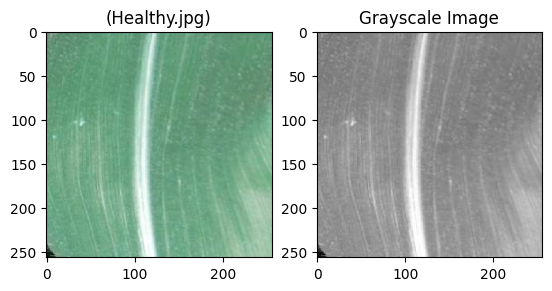

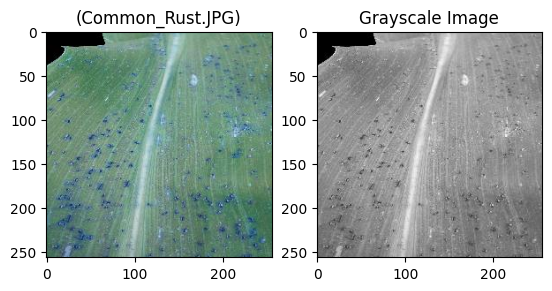

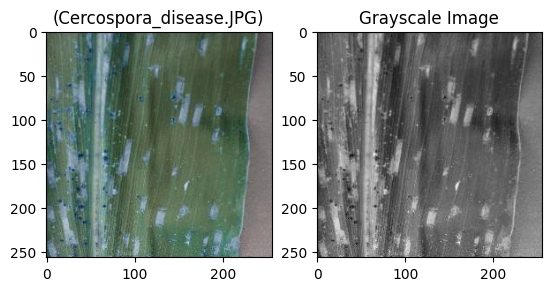

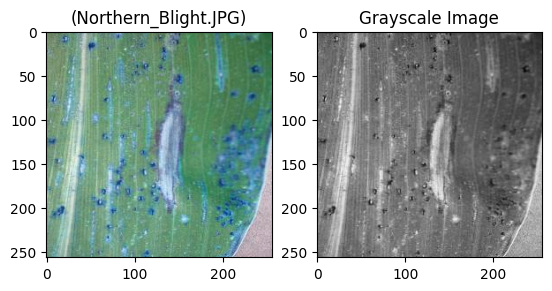

In [ ]:
test_dataset = '/content/drive/MyDrive/plant_data/Train_data'

cnt=0

# Loop through all image files in the directory
for filename in os.listdir(test_dataset):
    # Load the image and convert it to grayscale
    img = cv2.imread(os.path.join(test_dataset, filename))

    con_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cnt = cnt+1

    if cnt<5:
      # Display the original and grayscale images
      plt.subplot(1, 2, 1)
      plt.imshow(img)
      plt.title('({})'.format(os.path.basename(filename)))
      plt.subplot(1, 2, 2)
      plt.imshow(con_img, cmap='gray')
      plt.title('Grayscale Image')
      plt.show()

# Load the Dataset Path

---



In [ ]:
# Set the path to the image dataset folder
dataset_path = "/content/drive/MyDrive/plant_data/Train_data"

# K-means for segmentation

---



In [ ]:
def apply_kmeans(image):
    # Reshape the image to a 2D array
    pixels = image.reshape(-1, 1)

    # Initialize KMeans with 3 clusters and fit the data
    kmeans = KMeans(n_clusters=3, random_state=42).fit(pixels)

    # Get the cluster labels and reshape them to the original image size
    labels = kmeans.labels_.reshape(image.shape)

    # Return the clustered image
    return labels

# Otsu-Threshholding for segmentation

---



In [ ]:
def apply_otsu(image) :
  # Find Otsu threshold and binarize the image
  thresh = threshold_otsu(image)
  bin_img = image < thresh
  return bin_img* 255,thresh

# Applying all both segmentation techniques and comparing

---



Thresh hold for otsu Method is : 174



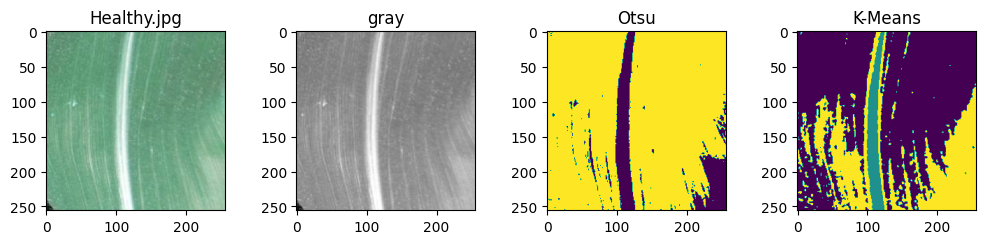


Thresh hold for otsu Method is : 73



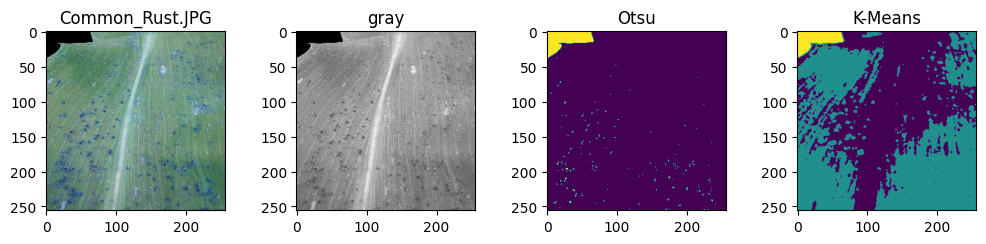


Thresh hold for otsu Method is : 111



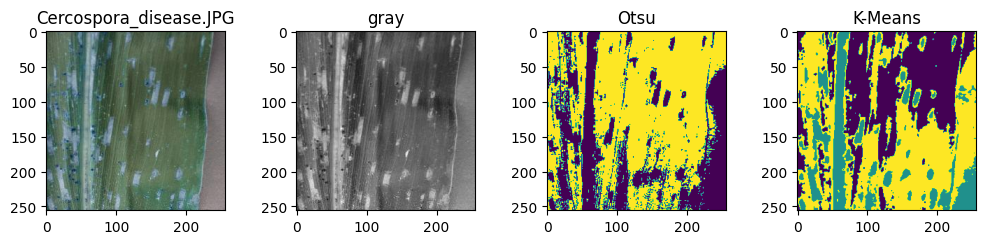


Thresh hold for otsu Method is : 149



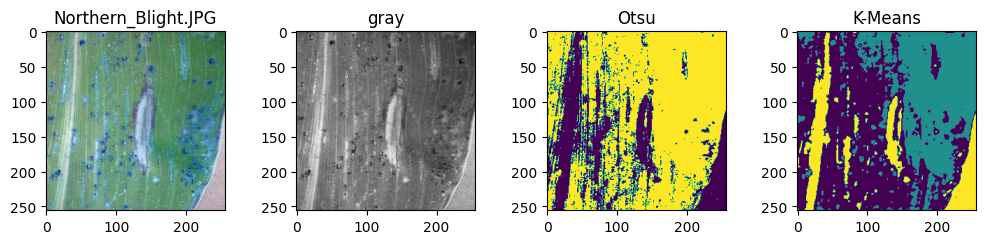

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Define the dimensions of the resized images
image_size = (256, 256)

# Loop over each image file in the dataset folder
for filename in os.listdir(dataset_path):
        # Load the image
        image = cv2.imread(os.path.join(dataset_path, filename))

        # Resize the image
        image = cv2.resize(image, image_size)

        # Convert the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # Apply K-means clustering to the preprocessed image
        clustered_img = apply_kmeans(blurred)

        # Apply Otsu Thresh holding to the preprocessed image
        otsu_img,thresh = apply_otsu(gray)

        # Printing Some images
        print("Thresh hold for otsu Method is : " + str(thresh))
        print()
        fig, axs = plt.subplots(1, 4, figsize=(12, 4))

        label = '{}'.format(os.path.basename(filename))
        axs[0].imshow(image)
        axs[0].set_title(label)

        label = 'gray'
        axs[1].imshow(gray, cmap='gray')
        axs[1].set_title(label)

        label = 'Otsu'
        axs[2].imshow(otsu_img)
        axs[2].set_title(label)

        label = 'K-Means'
        axs[3].imshow(clustered_img)
        axs[3].set_title(label)

        plt.subplots_adjust(wspace=0.4)
        plt.show()
        print()


In [ ]:
import os
import cv2
import shutil

dataset = '/content/drive/MyDrive/DATA_SET/'
Otsu_path = '/content/drive/MyDrive/plant_data/Preprocessed_otsu_dataset'
image_size = (256, 256)

# Loop over each image file in the dataset folder
for foldername in os.listdir(dataset):
    # Check if the current path is a directory
    if os.path.isdir(os.path.join(dataset, foldername)):
        # Create a new directory to save the Otsu images
        otsu_path = os.path.join(Otsu_path, f"{foldername}_otsu")
        os.makedirs(otsu_path, exist_ok=True)

        # Loop over each image file in the current directory
        for filename in os.listdir(os.path.join(dataset, foldername)):
            # Load the image
            image = cv2.imread(os.path.join(dataset, foldername, filename))

            # Resize the image
            image = cv2.resize(image, image_size)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply Gaussian blur to reduce noise
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)

            # Apply K-means clustering to the preprocessed image
            clustered_img = apply_kmeans(blurred)

            # Apply Otsu Thresh holding to the preprocessed image
            otsu_img,thresh = apply_otsu(gray)

            # Write the Otsu image to the corresponding new folder
            cv2.imwrite(os.path.join(otsu_path, filename), otsu_img)


# GLCM Matrix for feature extraction

---



In [ ]:

def GLCM(image) :
    # Calculate GLCM for all angles
    glcms = []
    theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # angles for GLCM
    theta1 = ["0","pi/4","pi/2","3*pi/4"]

    d = 1
    for angle in theta:
        glcm = graycomatrix(image, distances=[d], angles=[angle], levels=256, symmetric=True, normed=True)
        glcms.append(glcm)

    # Extract GLCM features
    headers = ["Angle", "Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Correlation", "Entropy"]
    table = PrettyTable(headers)

    i=0

    for glcm in glcms:
        contrast = graycoprops(glcm, 'contrast')
        dissimilarity = graycoprops(glcm, 'dissimilarity')
        homogeneity = graycoprops(glcm, 'homogeneity')
        energy = graycoprops(glcm, 'energy')
        correlation = graycoprops(glcm, 'correlation')
        ASM = graycoprops(glcm, 'ASM')
        entropy = shannon_entropy(glcm)

        row = [theta1[i], contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0], entropy]
        table.add_row(row)
        i = i+1

    return table


# Printing GLCM matrix (7 features) for all 4-Classes

---




GLCM Matrix for Healthy.jpg

GLCM Matrix for Preprocessed Image : 
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
| Angle  |      Contrast      |   Dissimilarity    |     Homogeneity     |          ASM          |        Energy       |    Correlation     |      Entropy       |
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
|   0    | 13.36392463235294  | 2.338679534313725  |  0.4029695400697429 |  0.002900283267891256 | 0.05385427808346572 | 0.9865349701326883 | 0.5822016904788471 |
|  pi/4  | 14.641445597846982 | 2.5672279892349095 | 0.36321745965719776 |  0.00239816283359504  | 0.04897104076487491 | 0.9852190777454486 | 0.5912591313269627 |
|  pi/2  | 2.7519148284313726 | 1.1579503676470588 |  0.544855811925859  |  0.004065450267212431 | 0.0637608835196974

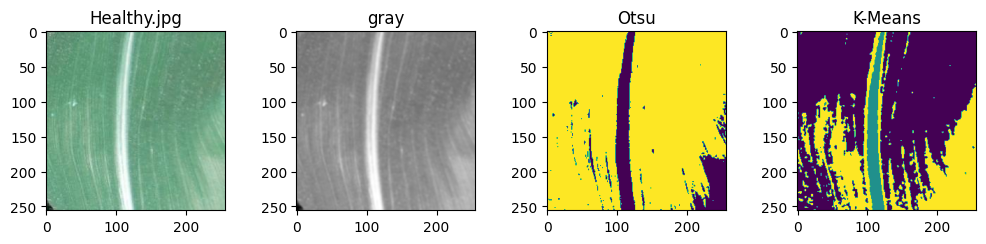


GLCM Matrix for Common_Rust.JPG

GLCM Matrix for Preprocessed Image : 
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
| Angle  |      Contrast      |   Dissimilarity    |     Homogeneity     |          ASM          |        Energy       |    Correlation     |      Entropy       |
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
|   0    | 16.832766544117646 | 2.7565104166666665 | 0.33976354173812073 | 0.0017431003522157943 | 0.04175045331748859 | 0.9882926403851455 | 0.6765150966891981 |
|  pi/4  | 34.201537870049975 | 3.7213225682429827 |  0.2791632240328607 |  0.001365358634577154 | 0.03695075959404832 | 0.9759781303345028 | 0.8083550704570086 |
|  pi/2  | 14.434941789215687 | 2.186688112745098  | 0.41525020720590916 |  0.002133507235423275 |  0.04618990404

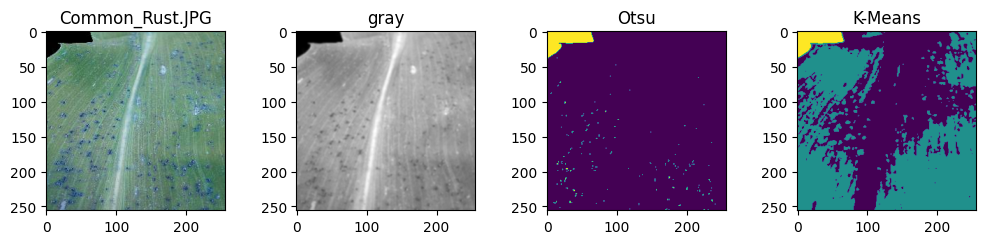


GLCM Matrix for Cercospora_disease.JPG

GLCM Matrix for Preprocessed Image : 
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
| Angle  |      Contrast      |   Dissimilarity    |     Homogeneity     |          ASM          |        Energy       |    Correlation     |      Entropy       |
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
|   0    | 31.296660539215683 | 3.711182598039216  | 0.31372196189016793 | 0.0010702337479875528 |  0.0327144272147252 | 0.9718351348725657 | 0.7964914501846837 |
|  pi/4  | 41.23577085736256  | 4.304006151480201  | 0.27314471195125894 |  0.000901180851832784 | 0.03001967441250461 | 0.9628906687528724 | 0.8720388379122884 |
|  pi/2  | 8.356295955882358  | 1.7784466911764711 |  0.4882745675810256 | 0.0021301470165846674 | 0.04615

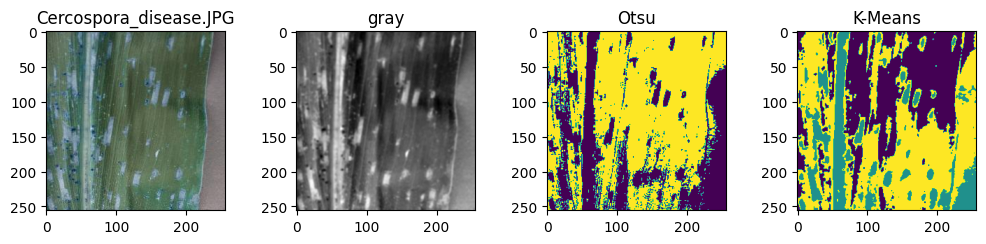


GLCM Matrix for Northern_Blight.JPG

GLCM Matrix for Preprocessed Image : 
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
| Angle  |      Contrast      |   Dissimilarity    |     Homogeneity     |          ASM          |        Energy       |    Correlation     |      Entropy       |
+--------+--------------------+--------------------+---------------------+-----------------------+---------------------+--------------------+--------------------+
|   0    | 27.837607230392162 | 3.613893995098039  |  0.2897716593758679 | 0.0010217068095429045 | 0.03196414881618005 | 0.9775007438081286 | 0.8416293675250806 |
|  pi/4  | 41.558400615148024 | 4.408012302960401  | 0.24737721784445862 | 0.0008373203989061081 | 0.02893648905631276 | 0.9664367838629386 | 0.9496666080833613 |
|  pi/2  | 10.878844975490194 | 2.1627604166666665 |  0.4157520470528512 | 0.0015744567659899437 |  0.0396794

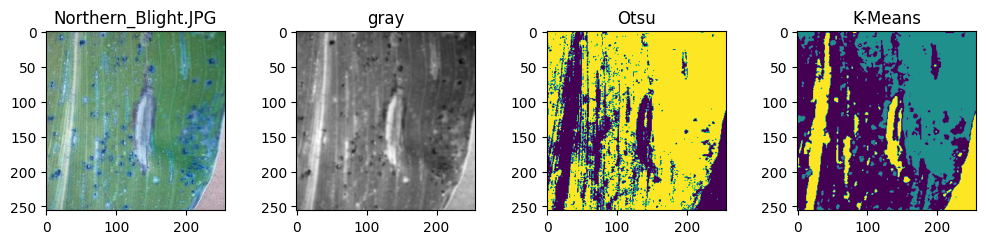

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Define the dimensions of the resized images
image_size = (256, 256)

# Loop over each image file in the dataset folder
for filename in os.listdir(dataset_path):
    print()
    print("GLCM Matrix for " + '{}'.format(os.path.basename(filename)))
    print()
    # Load the image
    image = cv2.imread(os.path.join(dataset_path, filename))

    # Resize the image
    image = cv2.resize(image, image_size)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply K-means clustering to the preprocessed image
    clustered_img = apply_kmeans(blurred)

    # Apply Otsu Thresh holding to the preprocessed image
    otsu_img, thresh = apply_otsu(gray)

    # Compute GLCM matrix for the preprocessed image
    print("GLCM Matrix for Preprocessed Image : ")
    print(GLCM(blurred))
    print()

    # Compute GLCM matrix for the Otsu-thresholded image
    print("GLCM Matrix for Otsu Thresh Holding Segmentation Image : ")
    print(GLCM(otsu_img))
    print()

    # Compute GLCM matrix for the K-means clustered image
    print("GLCM Matrix for K-Means Clustering Image : ")
    print(GLCM(clustered_img))
    print()

    # Display some images
    fig, axs = plt.subplots(1, 4, figsize=(12, 4))

    label = '{}'.format(os.path.basename(filename))
    axs[0].imshow(image)
    axs[0].set_title(label)

    label = 'gray'
    axs[1].imshow(blurred, cmap='gray')
    axs[1].set_title(label)

    label = 'Otsu'
    axs[2].imshow(otsu_img)
    axs[2].set_title(label)

    label = 'K-Means'
    axs[3].imshow(clustered_img)
    axs[3].set_title(label)

    plt.subplots_adjust(wspace=0.4)
    plt.show()


# Applying Feature Selection using RandomForest

---



In [ ]:
from sklearn.ensemble import RandomForestClassifier

def feature_extraction(image):
    # Calculate GLCM for all angles
    glcms = []
    Theta = ["0", "pi/4", "pi/2", "3pi/4"]
    theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # angles for GLCM
    d = 1
    for angle in theta:
        glcm = graycomatrix(image, distances=[d], angles=[angle], levels=256, symmetric=True, normed=True)
        glcms.append(glcm)

    # Extract GLCM features
    features = []
    for glcm in glcms:
        contrast = graycoprops(glcm, 'contrast')
        dissimilarity = graycoprops(glcm, 'dissimilarity')
        homogeneity = graycoprops(glcm, 'homogeneity')
        energy = graycoprops(glcm, 'energy')
        correlation = graycoprops(glcm, 'correlation')
        ASM = graycoprops(glcm, 'ASM')
        entropy = shannon_entropy(glcm)

        row = [contrast[0][0], dissimilarity[0][0], homogeneity[0][0], ASM[0][0], energy[0][0], correlation[0][0], entropy]
        features.append(row)

    # Fit Random Forest Classifier and extract feature importances
    X = np.array(features)
    y = np.array([0, 1, 2, 3])  # labels for each angle
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_

    # Print extracted features
    print("Extracted Features:")
    headers = ["Angle", "Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Correlation", "Entropy"]
    table = PrettyTable(headers)
    i = 0
    for glcm in glcms:
        row = [Theta[i], features[i][0], features[i][1], features[i][2], features[i][3], features[i][4], features[i][5], features[i][6]]
        table.add_row(row)
        i += 1
    print(table)

    # Print selected features
    print("\nSelected Features:")
    headers = ["Feature", "Importance"]
    table = PrettyTable(headers)
    feature_names = ["Contrast", "Dissimilarity", "Homogeneity", "ASM", "Energy", "Correlation", "Entropy"]
    for i in range(len(feature_names)):
        row = [feature_names[i], feature_importances[i]]
        table.add_row(row)
    print(table)

    # Return selected features
    selected_features = X[:, feature_importances.argsort()[::-1][:3]]  # Select top 3 features


# Printing Selected Features for all Classes

---



In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Define the dimensions of the resized images
image_size = (256, 256)

# Loop over each image file in the dataset folder
for filename in os.listdir(dataset_path):
    print()
    print("Feature Selection for " + '{}'.format(os.path.basename(filename)))
    print()
    # Load the image
    image = cv2.imread(os.path.join(dataset_path, filename))

    # Resize the image
    image = cv2.resize(image, image_size)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Otsu Thresh holding to the preprocessed image
    otsu_img, thresh = apply_otsu(blurred)

    print(feature_extraction(otsu_img))



Feature Selection for Healthy.jpg

Extracted Features:
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
| Angle |      Contrast      |   Dissimilarity    |    Homogeneity     |        ASM         |       Energy       |    Correlation     |       Entropy        |
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+
|   0   |   1024.98046875    |     4.01953125     | 0.9842373747616339 | 0.7847624855965479 | 0.8858682100609254 | 0.9210763978592833 | 0.001034097351833165 |
|  pi/4 | 1021.9999999999999 | 4.007843137254902  | 0.9842832097930059 | 0.7850406708093374 | 0.8860252089017204 | 0.9212136683611595 | 0.001034097351833165 |
|  pi/2 |    360.5859375     |     1.4140625      | 0.9944547421416049 |  0.79458425085529  | 0.8913945539744396 | 0.9722595745568905 | 0.00103409735

# Feature Selection using Hill Climbing

---



In [ ]:
# Define the properties to be extracted from GLCM
props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM', 'entropy']

# Define the distance and angle offsets for GLCM
distances = [1]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Define the path to the dataset
data_path = '/content/drive/MyDrive/plant_data/Preprocessed_otsu_dataset'

# Define the output file path
output_file = '/content/drive/MyDrive/plant_data/plant_features.csv'

# Initialize an empty list to store the feature vectors
feature_vectors = []

# Loop over the classes
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    # Loop over the images in the class
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        # Load the image and convert it to grayscale
        img = cv2.imread(file_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Compute the GLCM for each distance and angle offset
        glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)

        # Calculate the required texture features from the GLCM
        feature_vector = []
        for i, prop in enumerate(props[:-1]):
            # Add the feature column with the respective angle
            for j, angle in enumerate(angles):
                feature_name = f"{prop}_angle_{j}"
                feature_vector.append(graycoprops(glcm, prop)[0, j])

        # Calculate the entropy of the GLCM
        entropy = shannon_entropy(glcm)
        feature_vector.append(entropy)

        # Add the class label to the feature vector
        feature_vector.append(class_name)

        # Add the feature vector to the list
        feature_vectors.append(feature_vector)

# Convert the list of feature vectors to a pandas DataFrame
feature_df = pd.DataFrame(feature_vectors, columns=[f"{props[i]}_angle_{j}" for i in range(len(props)-1) for j in range(len(angles))] + ['entropy', 'class'])

# Save the feature DataFrame to a CSV file
feature_df.to_csv(output_file, index=False)


In [ ]:
featuress = pd.read_csv('/content/drive/MyDrive/plant_data/plant_features.csv')

In [ ]:
featuress

contrast_angle_0  contrast_angle_1  contrast_angle_2  contrast_angle_3  \
0          5050.189706       6313.012042       4942.125996       5124.622422   
1          7552.057384       8573.409104       6943.024464       7357.023360   
2          9076.268352       9915.324983       6049.273529       9587.251888   
3          6079.382154       7155.495794       6413.314216       5471.549896   
4         12145.338649      12631.411626       5498.596247      12653.951542   
...                ...               ...               ...               ...   
3860       8563.115165       7507.642199       6656.587531      11838.204060   
3861       7732.141376       8091.892072       4172.288082       8046.484998   
3862       1852.681112       2108.920200       1001.571768       2154.985975   
3863       2111.761029       2346.671111        810.900965       2160.700331   
3864       6029.826976       7522.938900       6820.319868       6837.076417   

      dissimilarity_angle_0  dissimilarity_angle_1  dissimilarity_angle_2  \
0                 20.395343              25.291596              19.984972   
1                 30.211091              34.158877              27.833410   
2                 36.475429              39.672695              24.614032   
3                 24.465977              28.624898              25.790809   
4                 48.545144              50.362676              22.479917   
...                     ...                    ...                    ...   
3860              34.460600              30.215087              26.998070   
3861              30.972963              32.319016              17.013971   
3862               7.522258               8.497224               4.184329   
3863               8.518964               9.413995               3.409911   
3864              24.392080              30.173041              27.514997   

      dissimilarity_angle_3  homogeneity_angle_0  homogeneity_angle_1  ...  \
0                 20.623037             0.747732             0.753703  ...   
1                 29.382576             0.724608             0.735324  ...   
2                 38.387051             0.607150             0.629335  ...   
3                 22.007013             0.727090             0.737549  ...   
4                 50.454425             0.570600             0.594454  ...   
...                     ...                  ...                  ...  ...   
3860              47.225790             0.613614             0.653600  ...   
3861              32.138793             0.706005             0.723053  ...   
3862               8.678585             0.889590             0.896261  ...   
3863               8.683599             0.891495             0.897387  ...   
3864              27.477309             0.685062             0.695848  ...   

      correlation_angle_0  correlation_angle_1  correlation_angle_2  \
0                0.817412             0.771643             0.821160   
1                0.697362             0.656047             0.720879   
2                0.661731             0.630395             0.775161   
3                0.806741             0.772509             0.796095   
4                0.602231             0.586187             0.819779   
...                   ...                  ...                  ...   
3860             0.716037             0.751159             0.779462   
3861             0.684419             0.669818             0.829936   
3862             0.942874             0.934969             0.969117   
3863             0.902946             0.892114             0.962638   
3864             0.810406             0.763610             0.785627   

      correlation_angle_3  ASM_angle_0  ASM_angle_1  ASM_angle_2  ASM_angle_3  \
0                0.814627     0.261027     0.269387     0.258522     0.274999   
1                0.704852     0.331859     0.340208     0.332695     0.344119   
2                0.642619     0.140020     0.152364     0.144698     0.153413   
3     

# Apply Hill-Climbing to all 4-Classes for feature selection

---



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from itertools import combinations

def calculate_cfs_score(data, features, target):
    k = len(features)

    # Compute the average correlation between features and target
    rzc = np.mean(data[features + [target]].corr().iloc[:-1, -1].values)

    # Compute the average inter-correlation between features
    rij = np.mean(data[features].corr().values)

    # Calculate the CFS score
    cfs_score = k * rzc / (np.sqrt(k + k * (k - 1) * rij))

    return cfs_score

def hill_climbing(data, target, max_iterations):
    best_features = []
    best_score = 0
    all_features = list(data.columns[:-1])
    current_features = list(np.random.choice(all_features, size=5, replace=False))

    for i in range(max_iterations):
        neighbors = []
        for feature in all_features:
            if feature not in current_features:
                neighbors.append(current_features + [feature])

        neighbor_scores = []
        for features in neighbors:
            X = data[features]
            y = data[target]
            model = LogisticRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            score = accuracy_score(y, y_pred)
            neighbor_scores.append(score)

        # Compute the CFS scores for the neighbor solutions
        cfs_scores = [calculate_cfs_score(data, features, target) for features in neighbors]

        # Find the index of the neighbor with the highest CFS score
        best_neighbor_idx = np.argmax(cfs_scores)
        best_neighbor_score = neighbor_scores[best_neighbor_idx]

        # Update the current features with the best neighbor if its score is higher than the current score
        if best_neighbor_score > best_score:
            best_score = best_neighbor_score
            best_features = neighbors[best_neighbor_idx]
            current_features = best_features

    print("Selected features:", best_features)
    print("Accuracy:", best_score)

    selected_df = data[best_features + [target]]

    return best_features, selected_df

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Load the original feature DataFrame
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/plant_features.csv')

# feature_df = pd.DataFrame(feature_df)

# Apply feature selection using hill climbing
selected_features, selected_df = hill_climbing(feature_df, "class", 100)

# Save the selected feature DataFrame to a CSV file
output_file = '/content/drive/MyDrive/plant_data/selected_plant_features.csv'
selected_df.to_csv(output_file, index=False)

Selected features: ['dissimilarity_angle_3', 'energy_angle_3', 'contrast_angle_1', 'dissimilarity_angle_2', 'homogeneity_angle_3', 'contrast_angle_2']
Accuracy: 0.5948253557567917


# Visualisation of the Selected features on our Preprocessed Dataset

---



# 1. Bar Chart: Class Distribution

---
This will display a bar chart showing the count of samples for each class.


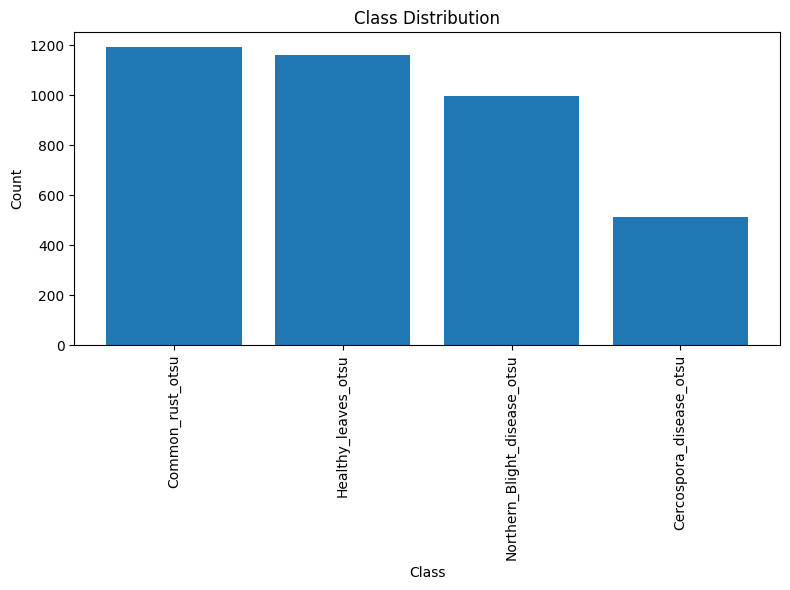

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

class_counts = data['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=90)  # Rotates the x-axis labels by 90 degrees
plt.tight_layout()  # Adjusts the spacing to prevent overlapping
plt.show()


# 2. Box Plot: Feature Comparison

---
This will show a box plot for each feature, grouped by class, allowing us to compare the distributions and identify any potential differences.

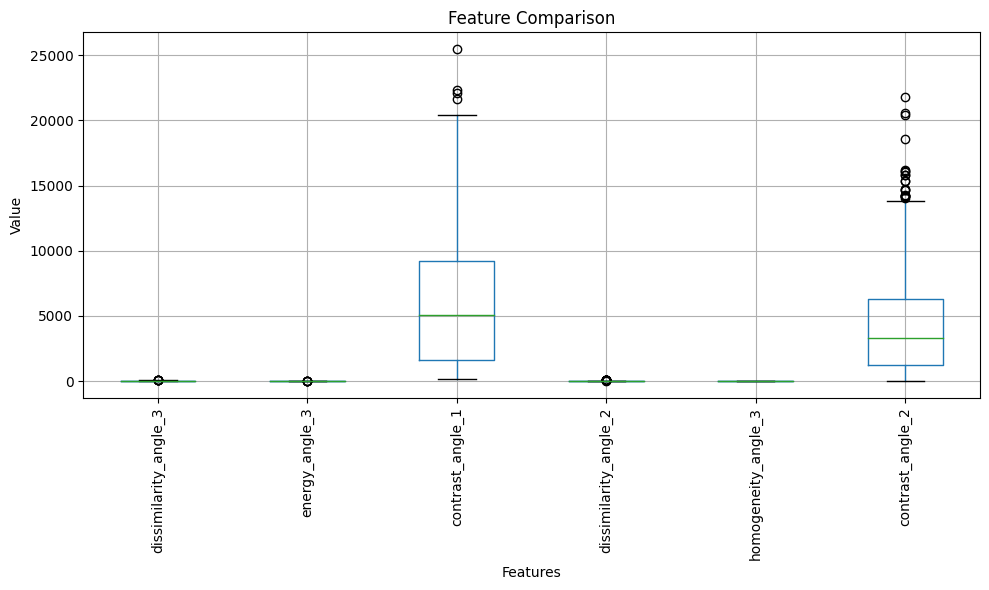

In [ ]:
plt.figure(figsize=(10, 6))
boxplot = data.drop('class', axis=1).boxplot()
plt.title('Feature Comparison')
plt.xlabel('Features')
plt.ylabel('Value')
plt.xticks(rotation=90)  # Rotates the x-axis labels by 90 degrees
plt.tight_layout()  # Adjusts the spacing to prevent overlapping
plt.show()

# 3. Pairwise Scatter Plot: Feature Relationships

---

This will generate a scatter plot matrix where each point represents the relationship between two features, with different colors indicating different classes.



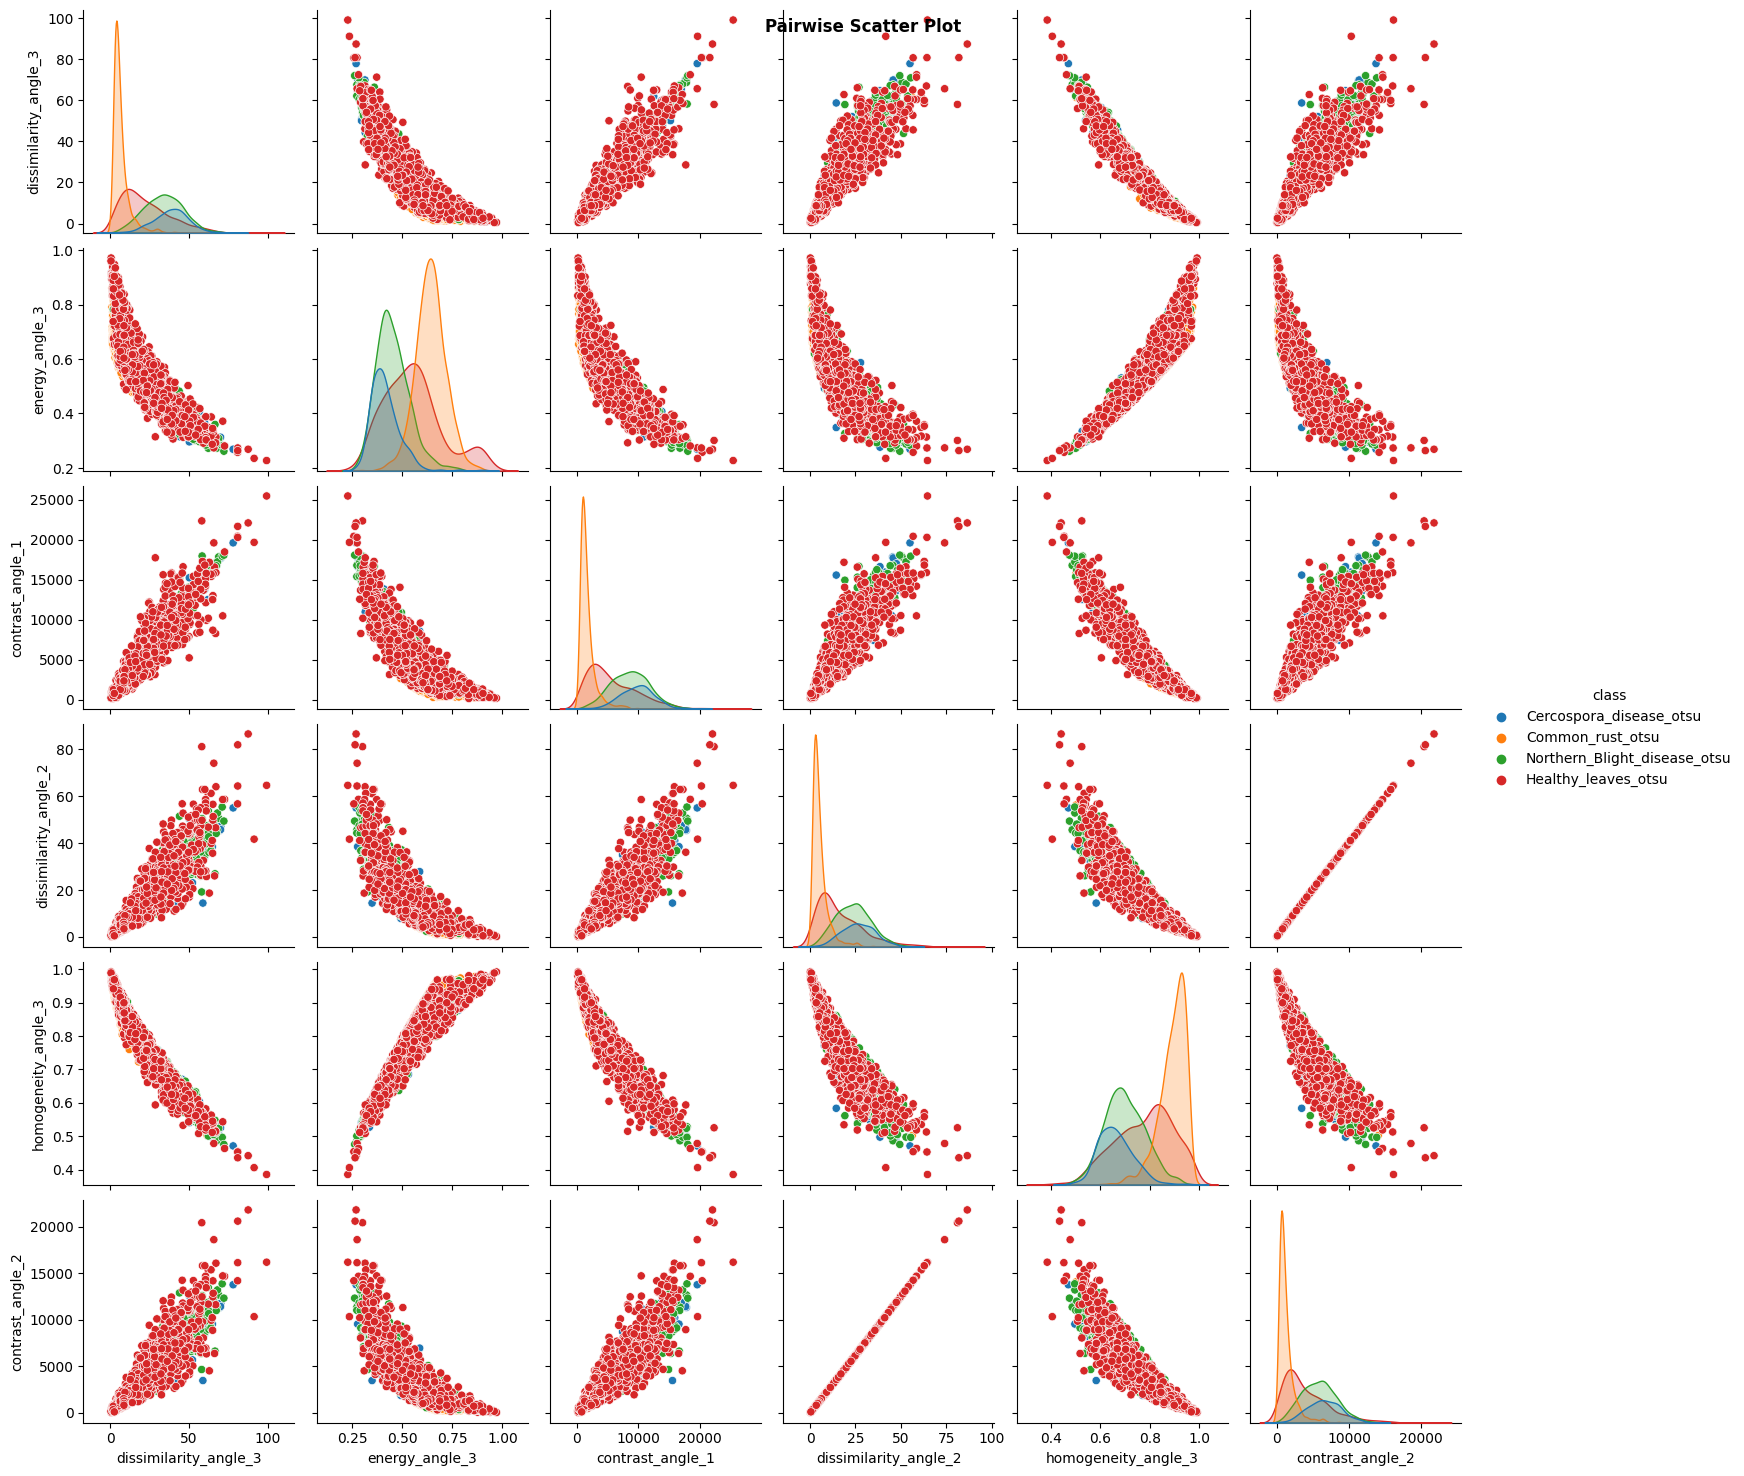

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the pair plot
sns.pairplot(data, hue='class')

# Set the title
plt.suptitle('Pairwise Scatter Plot', fontweight='bold')

# Display the plot
plt.show()

# 4. Histogram: Distribution of a Single Feature

---

This will display a histogram showing the distribution of the 'contrast' feature.

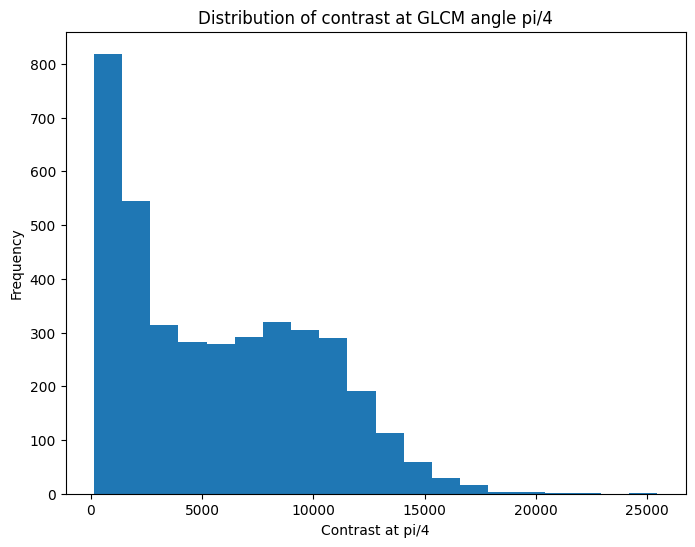

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

plt.figure(figsize=(8, 6))
plt.hist(data['contrast_angle_1'], bins=20)
plt.xlabel('Contrast at pi/4')
plt.ylabel('Frequency')
plt.title('Distribution of contrast at GLCM angle pi/4')
plt.show()

# 5. Heatmap: Correlation Matrix

---

This will generate a heatmap where each cell represents the correlation between two features. Higher values indicate stronger positive correlation, while lower values indicate negative correlation.

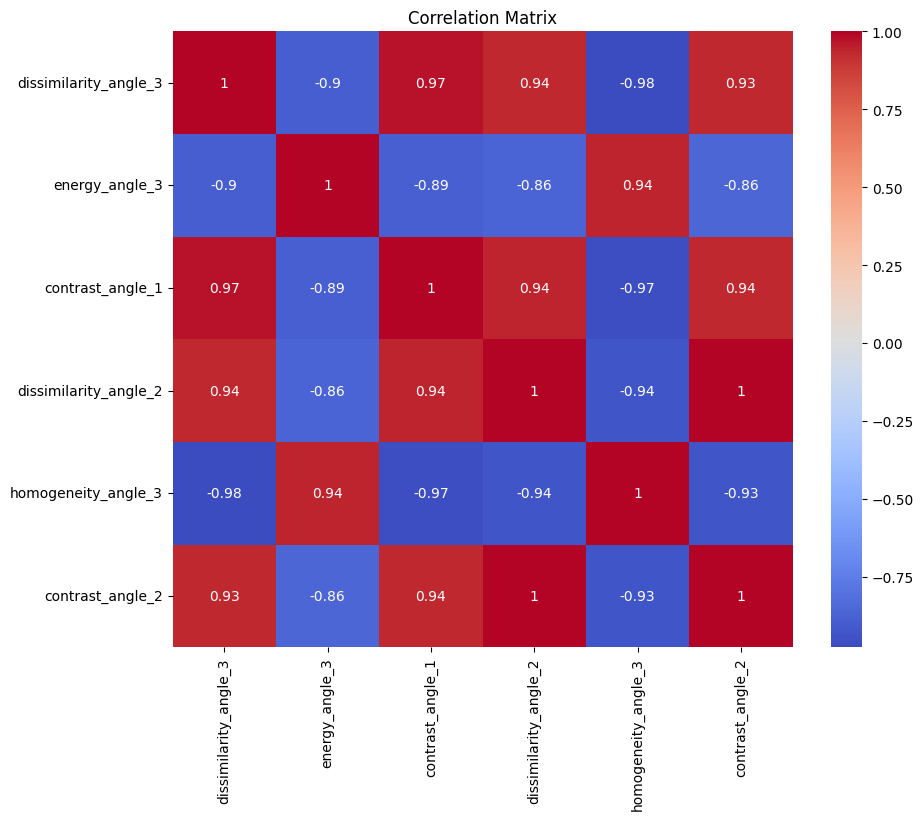

dissimilarity_angle_3  energy_angle_3  \
dissimilarity_angle_3               1.000000       -0.895174   
energy_angle_3                     -0.895174        1.000000   
contrast_angle_1                    0.969824       -0.891295   
dissimilarity_angle_2               0.935194       -0.860861   
homogeneity_angle_3                -0.976636        0.939185   
contrast_angle_2                    0.933313       -0.857610   

                       contrast_angle_1  dissimilarity_angle_2  \
dissimilarity_angle_3          0.969824               0.935194   
energy_angle_3                -0.891295              -0.860861   
contrast_angle_1               1.000000               0.940046   
dissimilarity_angle_2          0.940046               1.000000   
homogeneity_angle_3           -0.967198              -0.935059   
contrast_angle_2               0.938228               0.999966   

                       homogeneity_angle_3  contrast_angle_2  
dissimilarity_angle_3            -0.976636          0.933313  
energy_angle_3                    0.939185         -0.857610  
contrast_angle_1                 -0.967198          0.938228  
dissimilarity_angle_2            -0.935059          0.999966  
homogeneity_angle_3               1.000000         -0.932196  
contrast_angle_2                 -0.932196          1.000000

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
corr_matrix = data.drop('class', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

corr_matrix


In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

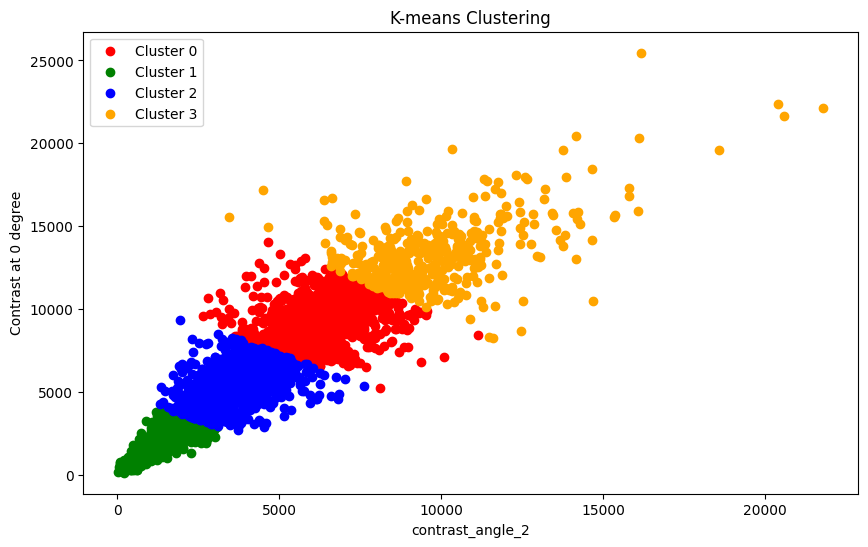

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Select the numerical features for clustering
features = ['dissimilarity_angle_3', 'energy_angle_3', 'contrast_angle_1', 'dissimilarity_angle_2', 'homogeneity_angle_3', 'contrast_angle_2']

# Extract the feature values
X = data[features].values

# Define the number of clusters
n_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the dataset
data['cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
colors = ['red', 'green', 'blue', 'orange']

for cluster_id, color in zip(range(n_clusters), colors):
    cluster_data = data[data['cluster'] == cluster_id]
    plt.scatter(cluster_data['contrast_angle_2'], cluster_data['contrast_angle_1'], c=color, label=f'Cluster {cluster_id}')

plt.xlabel('contrast_angle_2')
plt.ylabel('Contrast at 0 degree')
plt.title('K-means Clustering')
plt.legend()
plt.show()

# MACHINE LEARNING

---



# Model 1: CNN

---



In [ ]:
# pip install tensorflow keras

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define the path to the dataset
data_path = '/content/drive/MyDrive/DATA_SET'

In [ ]:
# Define the class names
class_names = os.listdir(data_path)

# Initialize empty lists for images and labels
images = []
labels = []

# Loop over the classes
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_path, class_name)

    # Loop over the images in the class
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)

        # Load the image and resize it to 128x128 pixels
        img = cv2.imread(file_path)
        img = cv2.resize(img, (128, 128))

        # Add the image and label to the lists
        images.append(img)
        labels.append(i)

# Convert the image and label lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42,shuffle="True")

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

CNN_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

CNN_model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=20)


Epoch 1/20
97/97 [==============================] - 484s 5s/step - loss: 2.7307 - accuracy: 0.8069 - val_loss: 46.1722 - val_accuracy: 0.5940
Epoch 2/20
97/97 [==============================] - 475s 5s/step - loss: 0.9869 - accuracy: 0.8523 - val_loss: 8.8509 - val_accuracy: 0.7095
Epoch 3/20
97/97 [==============================] - 460s 5s/step - loss: 0.7741 - accuracy: 0.8484 - val_loss: 10.3123 - val_accuracy: 0.6783
Epoch 4/20
97/97 [==============================] - 457s 5s/step - loss: 0.7175 - accuracy: 0.8767 - val_loss: 0.9377 - val_accuracy: 0.8405
Epoch 5/20
97/97 [==============================] - 456s 5s/step - loss: 0.4320 - accuracy: 0.8926 - val_loss: 0.6035 - val_accuracy: 0.8846
Epoch 6/20
97/97 [==============================] - 472s 5s/step - loss: 0.4219 - accuracy: 0.8922 - val_loss: 0.4086 - val_accuracy: 0.8911
Epoch 7/20
97/97 [==============================] - 467s 5s/step - loss: 0.9288 - accuracy: 0.8987 - val_loss: 0.9206 - val_accuracy: 0.8768
Epoch 8/20


In [ ]:
# Save the model
CNN_model.save('/content/drive/MyDrive/plant_data/plant_model.h5')

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Convert the one-hot encoded y_test to the original format
y_test_orig = np.argmax(y_test, axis=1)

y_pred = CNN_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)


# Calculate the accuracy score
accuracy = accuracy_score(y_test_orig, y_pred)
print("Accuracy:", accuracy)

25/25 [==============================] - 34s 1s/step
Accuracy: 0.7224383916990921


In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_orig, y_pred)

print(classification_report(y_test_orig, y_pred))

              precision    recall  f1-score   support

           0       0.37      1.00      0.54       125
           1       1.00      1.00      1.00       233
           2       0.00      0.00      0.00       185
           3       1.00      0.87      0.93       228

    accuracy                           0.72       771
   macro avg       0.59      0.72      0.62       771
weighted avg       0.66      0.72      0.67       771



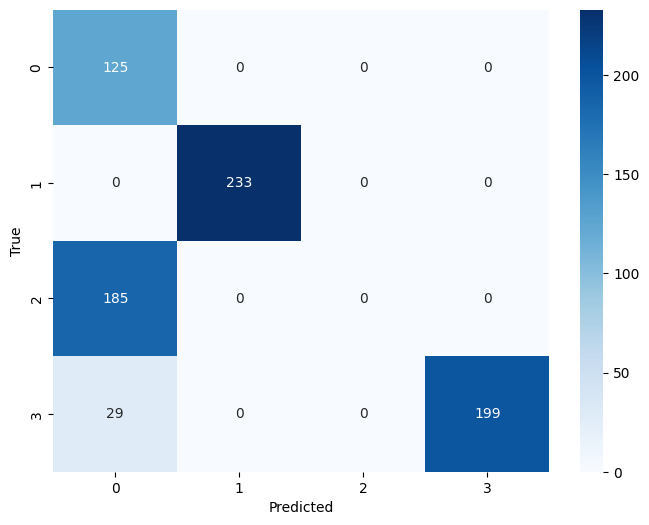

In [ ]:
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model 2: ANN

---



In [ ]:
import pandas as pd

# Read the CSV file into a dataframe
df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Shuffle the rows of the dataframe
shuffled_df = df.sample(frac=1)

# Write the shuffled dataframe back to a CSV file
shuffled_df.to_csv('shuffled_filename.csv', index=False)

In [ ]:
# shuffled_df

dissimilarity_angle_3  energy_angle_3  contrast_angle_1  \
2881              27.255855        0.444165       8986.417670   
3807              35.402261        0.448380       7949.364475   
2285              48.659577        0.342853      12989.970288   
1035               5.835509        0.592812       1368.636309   
2536              32.601538        0.407936       8161.424068   
...                     ...             ...               ...   
1087               5.771811        0.610732       1498.943206   
2251              62.126151        0.272311      15393.137762   
1341               7.231111        0.608193       2094.976794   
1548               2.202122        0.702886        434.618839   
272               20.286736        0.523268       5120.751511   

      dissimilarity_angle_2  homogeneity_angle_3  contrast_angle_2  \
2881              27.417785             0.696977       6793.814599   
3807              22.964154             0.675654       5656.887806   
2285              41.243566             0.586385      10267.570037   
1035               4.482629             0.886576       1063.596844   
2536              22.678079             0.673891       5579.457736   
...                     ...                  ...               ...   
1087               4.657108             0.903361       1121.015196   
2251              44.316621             0.500470      11007.293888   
1341               6.532858             0.887465       1587.514231   
1548               1.092816             0.962246        253.192019   
272               10.272794             0.798534       2494.623866   

                             class  
2881           Healthy_leaves_otsu  
3807           Healthy_leaves_otsu  
2285  Northern_Blight_disease_otsu  
1035              Common_rust_otsu  
2536  Northern_Blight_disease_otsu  
...                            ...  
1087              Common_rust_otsu  
2251  Northern_Blight_disease_otsu  
1341              Common_rust_otsu  
1548              Common_rust_otsu  
272        Cercospora_disease_otsu  

[3865 rows x 7 columns]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the feature data
feature_df = pd.read_csv('shuffled_filename.csv')
# feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Convert the class labels to one-hot encoded vectors
y = to_categorical(feature_df['class'].astype('category').cat.codes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), y, test_size=0.2, random_state=42,shuffle="True")

# Define the model architecture
ANN_model = Sequential()
ANN_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
ANN_model.add(Dense(64, activation='relu'))
ANN_model.add(Dense(32, activation='relu'))
ANN_model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
ANN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = ANN_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

# Evaluate the model on the test data
loss, accuracy = ANN_model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Epoch 1/100
97/97 [==============================] - 2s 5ms/step - loss: 34.9938 - accuracy: 0.2972 - val_loss: 20.4185 - val_accuracy: 0.4179
Epoch 2/100
97/97 [==============================] - 0s 3ms/step - loss: 11.8532 - accuracy: 0.3228 - val_loss: 14.2569 - val_accuracy: 0.1876
Epoch 3/100
97/97 [==============================] - 0s 3ms/step - loss: 9.3213 - accuracy: 0.3231 - val_loss: 11.8784 - val_accuracy: 0.4476
Epoch 4/100
97/97 [==============================] - 0s 3ms/step - loss: 7.2681 - accuracy: 0.3858 - val_loss: 8.5258 - val_accuracy: 0.2924
Epoch 5/100
97/97 [==============================] - 0s 3ms/step - loss: 9.5231 - accuracy: 0.3752 - val_loss: 14.0318 - val_accuracy: 0.3182
Epoch 6/100
97/97 [==============================] - 0s 3ms/step - loss: 9.1552 - accuracy: 0.4030 - val_loss: 10.5751 - val_accuracy: 0.2122
Epoch 7/100
97/97 [==============================] - 0s 3ms/step - loss: 8.2749 - accuracy: 0.4023 - val_loss: 7.3547 - val_accuracy: 0.3247
Epoch 

In [ ]:
# convert y_test to binary format
y_test_classes = np.argmax(y_test, axis=1)

# predict labels for test set
y_pred = ANN_model.predict(X_test)

# convert y_pred to binary format
y_pred_classes = np.argmax(y_pred, axis=1)

# calculate accuracy score
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# calculate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(classification_report(y_test_classes, y_pred_classes))

25/25 [==============================] - 0s 1ms/step
Accuracy: 0.6222509702457956
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.83      0.92      0.87       249
           2       0.75      0.37      0.50       246
           3       0.43      0.91      0.58       176

    accuracy                           0.62       773
   macro avg       0.50      0.55      0.49       773
weighted avg       0.60      0.62      0.57       773



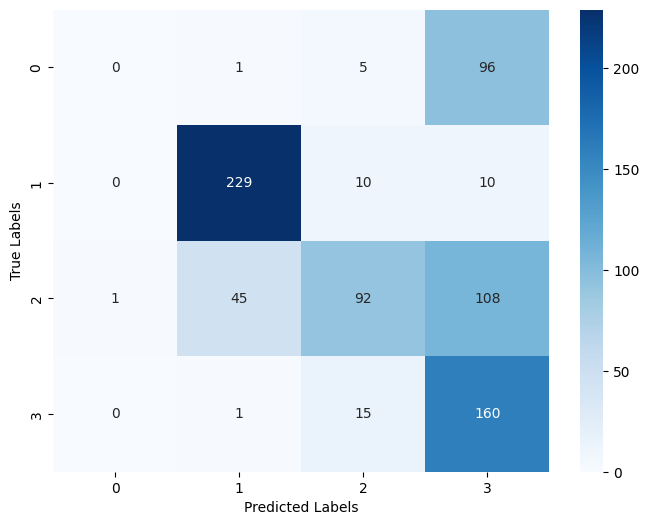

In [ ]:
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Model 3: RandomFrorest

---



In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the feature data
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), feature_df['class'], test_size=0.2, random_state=42,shuffle="True")

# Train a random forest classifier
RF_model = RandomForestClassifier(n_estimators=100, random_state=42)
RF_model.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = RF_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.48      0.26      0.34       123
            Common_rust_otsu       0.90      0.92      0.91       230
         Healthy_leaves_otsu       0.71      0.73      0.72       228
Northern_Blight_disease_otsu       0.52      0.65      0.58       192

                    accuracy                           0.69       773
                   macro avg       0.65      0.64      0.64       773
                weighted avg       0.68      0.69      0.68       773



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load the dataset
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), feature_df['class'], test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

Accuracy: 0.6532988357050453
                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.35      0.40      0.37       123
            Common_rust_otsu       0.91      0.92      0.91       230
         Healthy_leaves_otsu       0.74      0.69      0.71       228
Northern_Blight_disease_otsu       0.47      0.46      0.46       192

                    accuracy                           0.65       773
                   macro avg       0.62      0.62      0.62       773
                weighted avg       0.66      0.65      0.66       773



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

Accuracy: 0.6908150064683053
                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.48      0.26      0.34       123
            Common_rust_otsu       0.90      0.92      0.91       230
         Healthy_leaves_otsu       0.71      0.73      0.72       228
Northern_Blight_disease_otsu       0.52      0.65      0.58       192

                    accuracy                           0.69       773
                   macro avg       0.65      0.64      0.64       773
                weighted avg       0.68      0.69      0.68       773



In [ ]:
cm

array([[ 32,   0,  19,  72],
       [  0, 211,  11,   8],
       [  9,  19, 167,  33],
       [ 26,   5,  37, 124]])

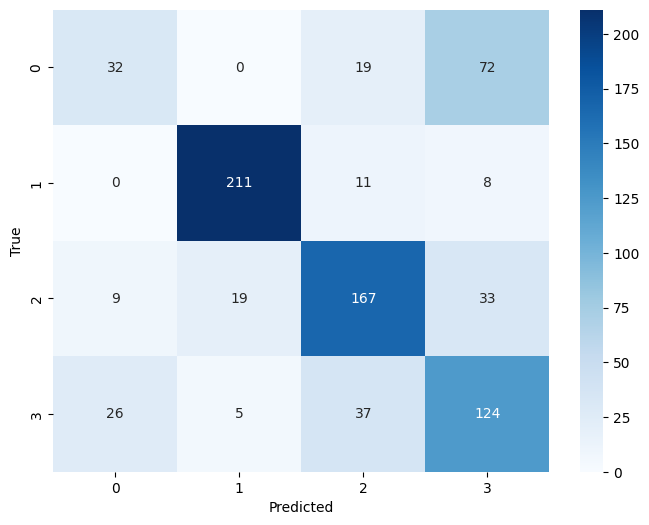

In [ ]:
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model 4: SVM

---



In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the feature data
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Extract the selected features
# selected_features = best_features + ['class']
# feature_df = feature_df[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), feature_df['class'], test_size=0.2, random_state=42,shuffle="True")

# Train an SVM model
SVM_model = SVC(kernel='rbf', C=1, gamma='scale')
SVM_model.fit(X_train, y_train)

# Predict the class labels for the test data
y_pred = SVM_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.00      0.00      0.00       123
            Common_rust_otsu       0.72      0.93      0.81       230
         Healthy_leaves_otsu       0.56      0.33      0.42       228
Northern_Blight_disease_otsu       0.45      0.81      0.58       192

                    accuracy                           0.57       773
                   macro avg       0.44      0.52      0.45       773
                weighted avg       0.49      0.57      0.51       773



In [ ]:
# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy: 0.574385510996119


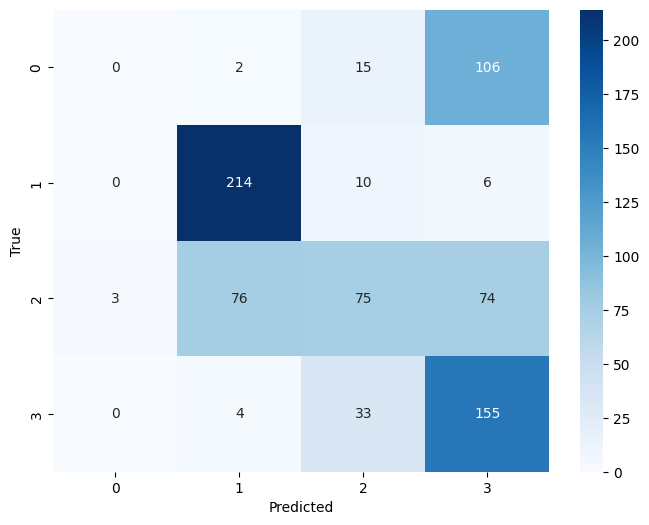

In [ ]:
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Model 5 : Decission Tree

---



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the dataset
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), feature_df['class'], test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

Accuracy: 0.630012936610608
                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.36      0.31      0.33       123
            Common_rust_otsu       0.88      0.87      0.88       230
         Healthy_leaves_otsu       0.66      0.62      0.64       228
Northern_Blight_disease_otsu       0.48      0.55      0.51       192

                    accuracy                           0.63       773
                   macro avg       0.59      0.59      0.59       773
                weighted avg       0.63      0.63      0.63       773



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd

# Load the dataset
feature_df = pd.read_csv('/content/drive/MyDrive/plant_data/selected_plant_features.csv')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(feature_df.drop('class', axis=1), feature_df['class'], test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))


Accuracy: 0.6002587322121604
                              precision    recall  f1-score   support

     Cercospora_disease_otsu       0.32      0.35      0.33       123
            Common_rust_otsu       0.86      0.88      0.87       230
         Healthy_leaves_otsu       0.63      0.58      0.60       228
Northern_Blight_disease_otsu       0.45      0.45      0.45       192

                    accuracy                           0.60       773
                   macro avg       0.56      0.56      0.56       773
                weighted avg       0.60      0.60      0.60       773



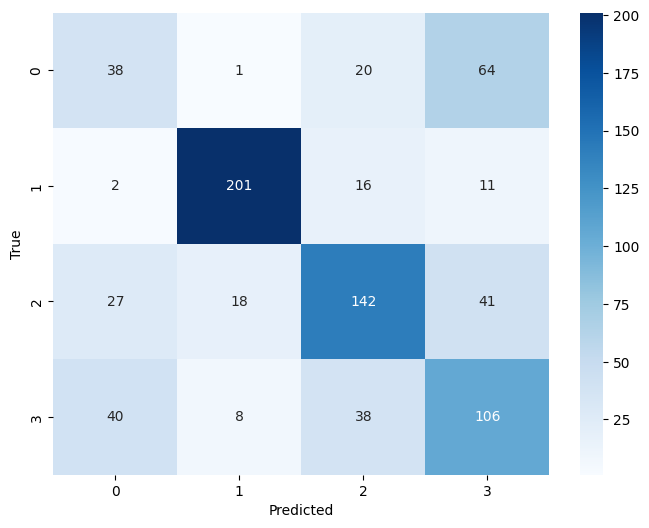

In [ ]:
import seaborn as sns

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()